# Description
The first part is focused on inferring the missing value about skin color rating using machine learning algorithm. The second part try to infer wether referees' behavior change depending of the skin-color of the player.

Let start by doing some imports.

In [1]:
import os
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt                         # Matplotlib's pyplot: MATLAB-like syntax
import seaborn as sns                                   # For pretty plots

## Skin-color inferring
First, as [mathewzila suggests](https://github.com/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb), the dataset used will be a disaggregate version of `data/CrowdstormingDataJuly1st.csv`. The reason being that it's more natural to deal with unaggregated data than aggregated ones.

Both will be imported in order to do some comparison.

In [2]:
df = pd.read_csv(os.path.join('data', 'CrowdstormingDataJuly1st.csv'))
df.head(10)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,1.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,...,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


In [3]:
dfd = pd.read_csv(os.path.join('data', 'crowdstorm_disaggregated.csv'))
dfd.head(10)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skintone,allreds,allredsStrict,refCount
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375,0,0,1
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750,0,0,1
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN,0,0,3
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN,0,0,3
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN,0,0,3
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,0,0,30
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,0,0,30
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000,0,0,30
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.250,0,0,30
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000,0,0,30


In [4]:
df_cols = set(df.columns)
dfd_cols = set(dfd.columns)

print("Number of lost columns: {}".format(len(df_cols - dfd_cols)))

Number of lost columns: 0


As we can see, the deaggregated dataset doesn't remove any columns from the base data set.

In [5]:
print("New columns: {}".format(dfd_cols - df_cols))

New columns: {'allreds', 'refCount', 'skintone', 'allredsStrict'}


As we can see, new columns are created. Based on [source code](https://osf.io/w7tds/),

- allredsStrict: If player has received a red without a yellow
- allreds: If player has received a red during this game (either because he had a yellow one before, or if he's directly received a red)
- skintone: Average of rater1 and rater2 for this player
- refCount: Number of dyads per referee (thus, how many player the referee is linked to)

All are indicator variable (either 1 if true, 0 o.w.)

**Remark**: the field `games` (i.e. count the number of match between the player and the referee) is redundant on `dfd`, since there is one observation per game.

### Look on skintone
As mentioned before, `skintone` is the mean between the two skin-color ratings

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ])

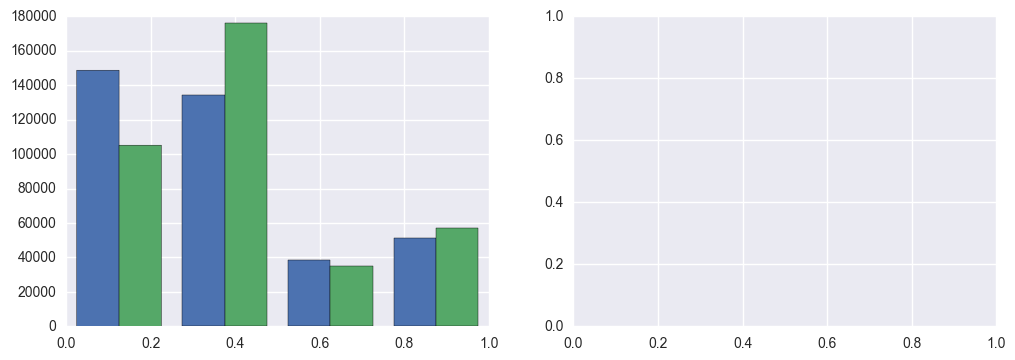

In [6]:
data_axe1 = [dfd["rater1"].dropna(inplace=False), dfd["rater2"].dropna(inplace=False)]
xaxis = np.sort(data_axe1[0].unique())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].hist(data_axe1, histtype='bar', bins=xaxis)

#fig.tight_layout()

xaxis